<a href="https://colab.research.google.com/github/annakopeikina/-annakopeikina-gEEKbRAIN_end-of-semestr_project/blob/main/8bf75400e9969514883649204e99f17d_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание

- [ ] Установите размер изображения равным 512
- [ ] Замените нейросеть на VGG-16
- [ ] Поменяйте вес вклада стиля и контента, в общую лосс-функцию (например, на 1000 к 1)
- [ ] Сгенерируйте собственное NST изображение для выбранных вами входных, контент- и стилевых изображений

In [13]:
%matplotlib inline

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg16, VGG16_Weights

import copy

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [16]:
device

device(type='cpu')

In [67]:
# Какого размера изображения мы хотим обрабатывать
imsize = 512 if torch.cuda.is_available() else 360 # Если нет GPU, делаем изображение поменьше

loader = transforms.Compose([
    transforms.Resize(imsize),  # масштабируем с сохранением соотношения сторон
    transforms.CenterCrop(imsize), # обрежем края чтобы получить квадратное изображение
    transforms.ToTensor()])  # преобразуем в нужный нам класс – Torch Tensor


def image_loader(image_name):
    # Загрузим и преобразуем картинку, вдруг она в оттенках серого или с альфа-каналом...
    image = Image.open(image_name).convert('RGB')
    # нейросеть ждет не просто картинку, а набор картинок
    # поэтому мы добавим к изображению одно мнимое измерение
    # (количество картинок в батче всегда будет равно 1)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("/content/images/image_style.jpg")
content_img = image_loader("/content/images/image_source.jpg")

assert style_img.size() == content_img.size(), \
    "Изображения должны быть одинакового размера, что-то пропущено в процедуре подготовки изображений"

Теперь создаем функцию, которая преобразует рабочую копию изображения обратно в PIL формат и отображает картинку при помощи ``plt.imshow``. И сразу используем ее чтобы вывести изображения – Стиль и Контент.

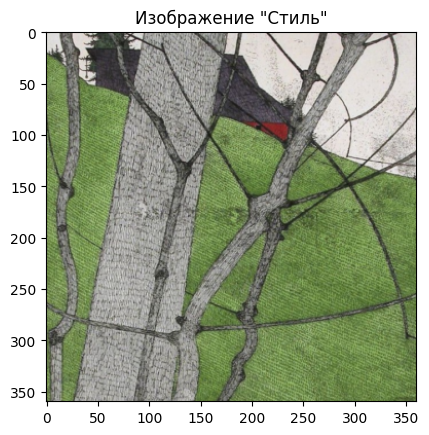

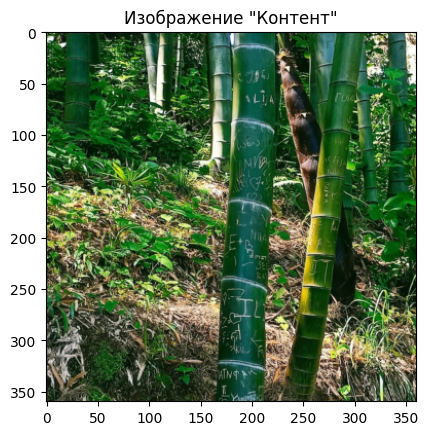

In [68]:
unloader = transforms.ToPILImage()  # Преобразуем в картинку PIL

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # создаем копию тензора чтобы не менять исходный
    image = image.squeeze(0)      # устраняем лишнее измерение (которое делало батч из изображения)
    image = unloader(image)
    plt.imshow(image)

    if title is not None:
        plt.title(title)
    plt.pause(0.001) # Дадим графику обновиться

plt.figure()
imshow(style_img, title='Изображение "Стиль"')

plt.figure()
imshow(content_img, title='Изображение "Контент"')

In [70]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()  # мы "замораживаем" целевое содержание (no grad)
        self.loss = 0

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input



Хотя модуль и называется ``ContentLoss``, он на самом деле не является настоящей лосс-функцией по всем правилам PyTorch. Ему не хватает функции  ``backward``, чтобы подсказать PyTorch, как производить автоматическое дифференцирование. Но мы не будем обучать эту нейросеть и ``backward`` не понадобится.

In [71]:
def gram_matrix(input):
    a, b, c, d = input.size()
    # a=размер батча(=1)
    # b=количество карт признаков, для которых мы считаем матрицу
    # (c,d)=размерность карты признаков f (N=c*d)

    features = input.view(a * b, c * d)  # изменим размерность матрицы F_XL, получим \hat F_XL

    G = torch.mm(features, features.t())  # рассчитать произведение матриц чтобы получить матрицу Грама

    # нормализуем значения матрицы Грама, разделив значения матрицы на количество элементов
    return G.div(a * b * c * d)

Модуль для расчета расстояния по стилю между двумя изображениями очень похож на уже реализованный модуль для расчета расстояния по содержимому. Расстояние по стилю рассчитывается как СКО между $G_{XL}$ и $G_{SL}$.

In [72]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [73]:
cnn = vgg16(weights=VGG16_Weights.DEFAULT).features.eval()

Как и другие сети, VGG лучше работает с нормализованными изображениями. Параметры нормализации исходного датасета – mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] (мат.ожидание и дисперсия). Поэтому перед отправкой в сеть мы нормализуем наши изображения при помощи этих статистических параметров.

In [74]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# упаковочный класс, чтобы картинку было легче передать в объект ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # преобразуем мат.ожидание и дисперсию при помощи .view так, чтобы
        # их можно было легко умножить на тензор с картинкой
        # Картинка имеет размерность [B x C x H x W]
        # Мы приводим коэффициенты нормализации к размерности [C x 1 x 1]
        # B – размер батча. C – количество каналов. H – высота, W – ширина изображения.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # нормализуем изображение ``img``
        return (img - self.mean) / self.std

Объект ``Sequential`` обычно служит для объявления нейросети, слой за слоем, или другого набора вложенных модулей.

К примеру, ``vgg19.features`` тоже содержит набор вложенных модулей (``Conv2d``, ``ReLU``, ``MaxPool2d``, ``Conv2d``, ``ReLU``…) в нужном порядке. Измерять расхождение по стилю и содержимому мы будем сразу после некоторых из сверточных слоев ``Conv2d``.

Для этого мы фактически создаем новую нейросеть, в которой в большой объекте ``Sequential`` будут содержаться все слои для вычисления расхождений.

Кстати, ниже мы определяем свою конвенцию для именования слоев (изначально у слоев модели нет имен).

In [75]:
# названия слоев, где мы будем рассчитывать расхождение по контенту
content_layers_default = ['conv_4']

# названия слоев, где мы будем рассчитывать расхождение по стилю
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default,
                               content_weight=1.5, style_weight=1):
    normalization = Normalization(normalization_mean, normalization_std)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target) * content_weight
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature) * style_weight
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, content_losses, style_losses


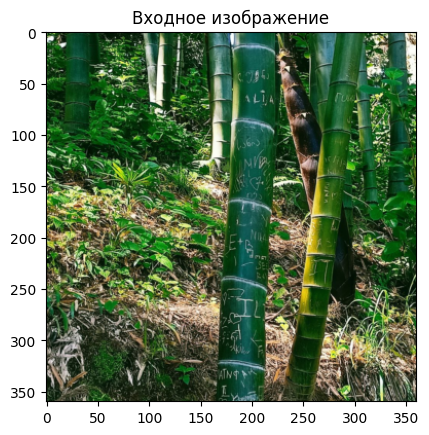

In [76]:
# Чтобы использовать исходную картинку, раскомментируйте:
input_img = content_img.clone()

# Чтобы использовать шум
#input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Входное изображение')

In [77]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [78]:
import torch.nn as nn
import torch.nn.functional as F

class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = target.detach()  # мы "замораживаем" целевое содержание (no grad)
        self.loss = 0

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


In [79]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=100, content_weight=1):

    print('Построение модели переноса стиля..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # Укажем, какой объект мы будем оптимизировать (включить параметр requires_grad fields)
    input_img.requires_grad_(True)
    # Переключим модель в режим исполнения, чтобы заморозить слои вроде dropout или батч нормализации normalization layers
    model.eval()
    # Очевидно, мы не будем оптимизировать модель, так что заморозим все параметры
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Оптимизируем картинку..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # скорректируем значения входного изображения
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad() # обнуляем градиенты (иногда их используют между итерациями, но не сейчас)
            model(input_img) # знакомая вам функция, отправить картинку в модель

            # Посчитаем расхождение изображений по стилю и содержимому
            style_score = 0
            content_score = 0

            for sl in style_losses: style_score += sl.loss
            for cl in content_losses: content_score += cl.loss

            style_score *= style_weight # Домножаем каждую компоненту лосса на заданный вес
            content_score *= content_weight

            loss = style_score + content_score
            # И по этому значению осуществляем обратное распространение ошибки (обратно по сети, вплоть до изображения)
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # и в последний раз вернем изображение в диапазон
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    normalization = Normalization(normalization_mean, normalization_std)
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)
    i = 0

    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=10, content_weight=1):

    print('Построение модели переноса стиля..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    input_img.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Оптимизируем картинку..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)

            style_score = 0
            content_score = 0

            for sl in style_losses: style_score += sl.loss
            for cl in content_losses: content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)
        torch.cuda.empty_cache()  # Очистка кэша GPU

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img


In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Полученное изображение')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Построение модели переноса стиля..
Оптимизируем картинку..


In [46]:
import torch

def clear_cache():
    # Проверяем, доступна ли CUDA
    if torch.cuda.is_available():
        print(f"Использование памяти перед очисткой: {torch.cuda.memory_allocated()} байт")

        # Очищаем кэш CUDA
        torch.cuda.empty_cache()

        print(f"Использование памяти после очистки: {torch.cuda.memory_allocated()} байт")
    else:
        print("CUDA недоступна, очистка кэша не требуется.")


## Библиография

[Image Stylization: History and Future (Part 1)](https://research.adobe.com/news/image-stylization-history-and-future/), Adobe Research 2018

[Intro | Neural Style Transfer #1](https://www.youtube.com/watch?v=S78LQebx6jo), [Basic Theory | Neural Style Transfer #2](https://www.youtube.com/watch?v=B22nIUhXo4E&t=199s)...

[Neural Transfer Using PyTorch](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)

NST на tensorflow: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb

[Visualizing Feature Maps using PyTorch](https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573)

In [ ]:
clear_cache()

Использование памяти перед очисткой: 90317824 байт
Использование памяти после очистки: 90317824 байт
